<a href="https://colab.research.google.com/github/aumrcn/261459-Eye-Diseases-Classification/blob/main/%5BMaster%5D_%5BED69%5D_Eye_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
%reset -f

from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lapasradakumjulla","key":"09c225811ed9ea9812d4ff52b118e2e1"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

100% 735M/736M [01:01<00:00, 14.6MB/s]
100% 736M/736M [01:01<00:00, 12.6MB/s]


In [ ]:
! rm -r dataset

rm: cannot remove 'dataset': No such file or directory


In [ ]:
! unzip eye-diseases-classification.zip &> /dev/null

# Split data into train, validation, test directory

## Create directory

In [ ]:
import os
import numpy as np
import shutil

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [ ]:
! rm -r dataset/train
! rm -r dataset/test
! rm -r dataset/val

rm: cannot remove 'dataset/train': No such file or directory
rm: cannot remove 'dataset/test': No such file or directory
rm: cannot remove 'dataset/val': No such file or directory


In [ ]:
# # Creating Train / Val / Test folders (One time use)
root_dir = 'dataset'
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

for cls in classes:
  os.makedirs(root_dir +'/train/' + cls)
  os.makedirs(root_dir +'/val/' + cls)
  os.makedirs(root_dir +'/test/' + cls)

## Load & Trim train data so no class has more than 700 images

In [ ]:
import os
import copy
from PIL import Image

> Generating rotated image files takes very long time, so we just randomly rotate the image in the model itself instead

In [ ]:
GENERATE_ROTATED_IMAGE_FILES = False
RANDOM_SEED = False
SEED = 0

def generate_rot_images(degree,fileNames,append_to = []):
  fNames = copy.copy(fileNames)
  count = 1
  for name in fNames:
    print(f'generate_rot_images: #{count} {name} at {degree} degree ')
    count += 1
    #read the image
    im = Image.open(name)
    splitted = os.path.splitext(name)
    fname = splitted[0]
    ext = splitted[1]
    #rotate image
    out = im.rotate(degree)
    #save file
    out_name = f'{fname}_rot{degree}.{ext}'
    out.save(out_name)
    append_to.append(out_name)

# Creating partitions of the data after shuffeling
def loadDataset(current_class):
  src = "dataset/"+current_class # Folder to copy images from

  TRAIN_RATIO = 0.7
  VAL_RATIO = 0.15
  TEST_RATIO = 0.15

  allFileNames = os.listdir(src)

  if(not RANDOM_SEED):
    np.random.seed(seed=SEED)

  np.random.shuffle(allFileNames)
  train_fileNames, val_fileNames, test_fileNames = np.split(np.array(allFileNames),
                                                            [int(len(allFileNames)*(1 - (VAL_RATIO + TEST_RATIO))), 
                                                            int(len(allFileNames)*(1 - VAL_RATIO))])  


  train_fileNames = [src+'/'+ name for name in train_fileNames.tolist()]
  val_fileNames = [src+'/' + name for name in val_fileNames.tolist()]
  test_fileNames = [src+'/' + name for name in test_fileNames.tolist()]

  ## Trim train_FilesNames
  TRIM_MAX = 700
  arr = range(len(train_fileNames))
  remove_index = np.random.choice(arr, len(arr) - TRIM_MAX, replace=False)
  
  train_fileNames = np.delete(train_fileNames, remove_index).tolist()

  ## Generate 90,180,270 degrees rotated images
  if(GENERATE_ROTATED_IMAGE_FILES):
    train_fNames = copy.copy(train_fileNames)
    generate_rot_images(90,train_fNames,train_fileNames)
    generate_rot_images(180,train_fNames,train_fileNames)
    generate_rot_images(270,train_fNames,train_fileNames)


  print(current_class, '\n\t Total images: ', len(allFileNames) - (len(arr) - TRIM_MAX))
  print('\t Training: ', len(train_fileNames))
  print('\t Validation: ', len(val_fileNames))
  print('\t Testing: ', len(test_fileNames))

  # Copy-pasting images
  for name in train_fileNames:
    shutil.copy(name, "dataset/train/"+current_class)

  for name in val_fileNames:
    shutil.copy(name, "dataset/val/"+current_class)

  for name in test_fileNames:
    shutil.copy(name, "dataset/test/"+current_class)

In [ ]:
loadDataset('cataract')
loadDataset('diabetic_retinopathy')
loadDataset('glaucoma')
loadDataset('normal')

cataract 
	 Total images:  1012
	 Training:  700
	 Validation:  156
	 Testing:  156
diabetic_retinopathy 
	 Total images:  1030
	 Training:  700
	 Validation:  165
	 Testing:  165
glaucoma 
	 Total images:  1003
	 Training:  700
	 Validation:  151
	 Testing:  152
normal 
	 Total images:  1023
	 Training:  700
	 Validation:  161
	 Testing:  162


# Load data into Dataset object

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import copy
import math

import numpy as np

from itertools import chain

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

Hyperparams

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 512
CLASS_MODE = 'categorical'

Train data

In [ ]:
train_ds = image_dataset_from_directory(
    directory='dataset/train',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)
train_ds.batch(BATCH_SIZE)

##########

validation_ds = image_dataset_from_directory(
    directory='dataset/val',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE))
validation_ds.batch(BATCH_SIZE)

##########

test_ds = image_dataset_from_directory(
    directory='dataset/test',
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE))
test_ds.batch(BATCH_SIZE)


Found 2800 files belonging to 4 classes.
Found 633 files belonging to 4 classes.
Found 635 files belonging to 4 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None))>

# Visualizing training set images

In [ ]:
train_dl = list(train_ds.as_numpy_iterator())

In [ ]:
labels_map = {
    0: "cataract",
    1: "diabetic_retinopathy",
    2: "glaucoma",
    3: "normal",
}

rgb_map = {
    0: "R",
    1: "G",
    2: "B",
}

`DirectoryIterator` is *batched* and i can't unbatch it
- `train_dl[0]` is batch 0
- `train_dl[0][0]` is batch 0 images
- `train_dl[0][1]` is batch 0 labels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
SAMPLE_BATCH = 0    # 0-21
SAMPLE_INDEX = 0   # 0-127

def one_hot_to_int(one_hot):
  for i in range(len(one_hot)):
    if(one_hot[i] == 1):
      return i
  return -1

def batch_one_hot_to_int(one_hots):
  return [np.where(r == 1)[0][0]
      for r in one_hots
   ]

train_images = train_dl[SAMPLE_BATCH][0]
train_labels = batch_one_hot_to_int(train_dl[SAMPLE_BATCH][1])

print("Shape: ", train_images[SAMPLE_INDEX].shape)
print("Label: ", train_labels[SAMPLE_INDEX], "->", labels_map[train_labels[SAMPLE_INDEX]])

Shape:  (256, 256, 3)
Label:  1 -> diabetic_retinopathy


Example: Extracting channels


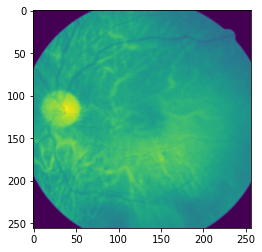

In [ ]:
img_r = train_images[SAMPLE_INDEX, :, :, 0]
img_g = train_images[SAMPLE_INDEX, :, :, 1]
img_b = train_images[SAMPLE_INDEX, :, :, 2]

plt.imshow(img_r)

In [ ]:
import random

import matplotlib.pyplot as plt
import seaborn as sns

### Define sampleImage()

In [ ]:
def sampleImage(img_count = 1, sample_batch = -1, sample = -1, split_channel = False, width = 15, height = 15, file_name = ""):
  if split_channel:
    fig, ax = plt.subplots(img_count,3,figsize=(height,width))
    fig.subplots_adjust(hspace = 0.6)
    for j in range(0,img_count):
      #####
      if(sample_batch == -1):
        sample_batch_idx = random.randint(0, len(train_dl)-1)
      else:
        sample_batch_idx = sample_batch

      if(sample == -1):
        sample_idx = random.randint(0, len(train_dl[sample_batch_idx][0])-1)
      else:
        sample_idx = sample
      #####

      img = train_dl[sample_batch_idx][0][sample_idx]
      label = one_hot_to_int(train_dl[sample_batch_idx][1][sample_idx])


      imgs = []
      for i in range(0,3):
        imgs.append(img[:, :, i])
        if img_count == 1:
          ax[i].imshow(imgs[i], cmap='viridis') 
          ax[i].set_title(
            f"batch:{sample_batch_idx} sample:{sample_idx} \n{labels_map[label]} {rgb_map[i%3]} \nmax = {str(imgs[0].max().item())} \nmin = {str(imgs[0].min().item())}",
            fontsize=14 )
        else:
          ax[j][i].imshow(imgs[i], cmap='viridis')
          ax[j][i].set_title(
              f"batch:{sample_batch_idx} sample:{sample_idx} \n{labels_map[label]} {rgb_map[i%3]} \nmax = {str(imgs[0].max().item())} \nmin = {str(imgs[0].min().item())}",
              fontsize=14 )
          ax[j][i].set_xticks(np.arange(0, 256+1, 32))
          ax[j][i].set_yticks(np.arange(0, 256+1, 32))
          ax[j][i].tick_params(axis='both', which='major', labelsize=10)
          ax[j][i].tick_params(axis='both', which='minor', labelsize=8)
          ax[j][i].grid(False)
  else:
    nRows = int((img_count-1)/3+1)
    fig, ax = plt.subplots(nRows,3,figsize=(height,width))
    fig.subplots_adjust(hspace = 0.6)
    for i in range(0,nRows*3):
      #####
      if(sample_batch == -1):
        sample_batch_idx = random.randint(0, len(train_dl)-1)
      else:
        sample_batch_idx = sample_batch

      if(sample == -1):
        sample_idx = random.randint(0, len(train_dl[sample_batch_idx][0])-1)
      else:
        sample_idx = sample
      #####

      img = train_dl[sample_batch_idx][0][sample_idx]
      label = one_hot_to_int(train_dl[sample_batch_idx][1][sample_idx])

      img = img.astype('uint8')

      if img_count <= 3:
        if i >= img_count:
          ax[i].axis("off")
        else:
          ax[i].imshow(img, cmap='viridis')
          ax[i].set_title(
              f"batch:{sample_batch_idx} sample:{sample_idx} \n{labels_map[label]} RGB \nmax = {str(img.max().item())} \nmin = {str(img.min().item())}", 
              fontsize=14 )
      else:
        if i >= img_count:
          ax[int(i/3)][i%3].axis("off")
        else:
          ax[int(i/3)][i%3].imshow(img, cmap='viridis')
          ax[int(i/3)][i%3].set_title(
              f"batch:{sample_batch_idx} sample:{sample_idx} \n{labels_map[label]} RGB \nmax = {str(img.max().item())} \nmin = {str(img.min().item())}",
              fontsize=14 )
          ax[int(i/3)][i%3].set_xticks(np.arange(0, 256+1, 32))
          ax[int(i/3)][i%3].set_yticks(np.arange(0, 256+1, 32))
          ax[int(i/3)][i%3].tick_params(axis='both', which='major', labelsize=10)
          ax[int(i/3)][i%3].tick_params(axis='both', which='minor', labelsize=8)
          ax[int(i/3)][i%3].grid(False)
  if file_name != "":
    plt.savefig(file_name, bbox_inches='tight')

### Sample images



Sample images: RGB

> result is best when imgCount is divisible by 3

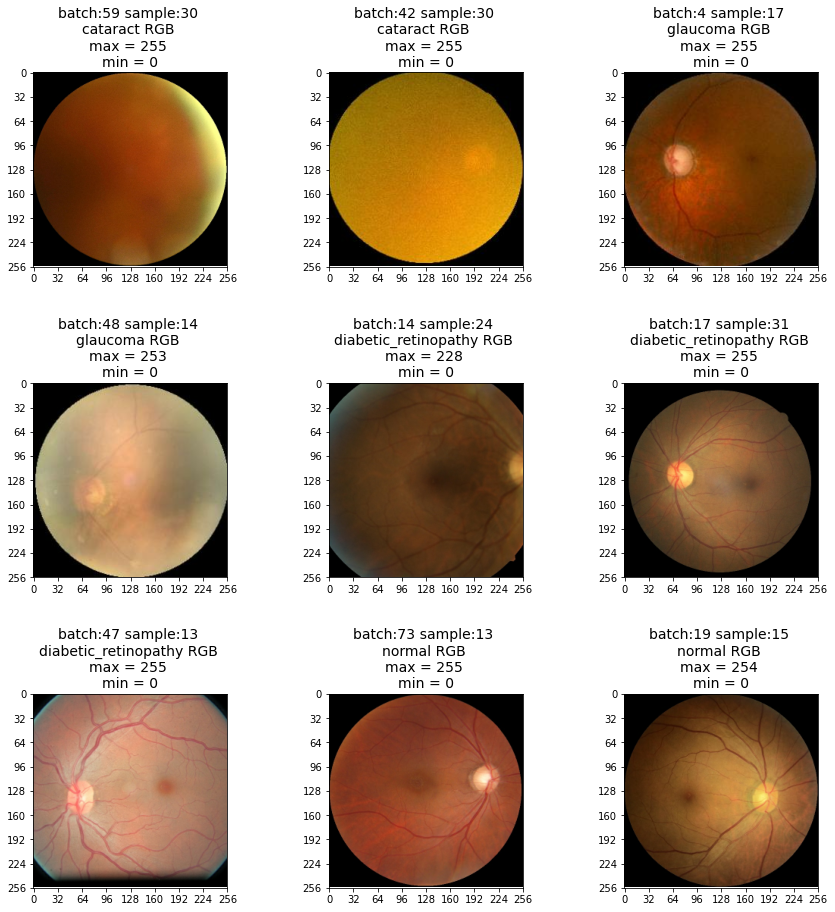

In [ ]:
sampleImage(9, file_name = "sample_01.png")

Sample images: split channel

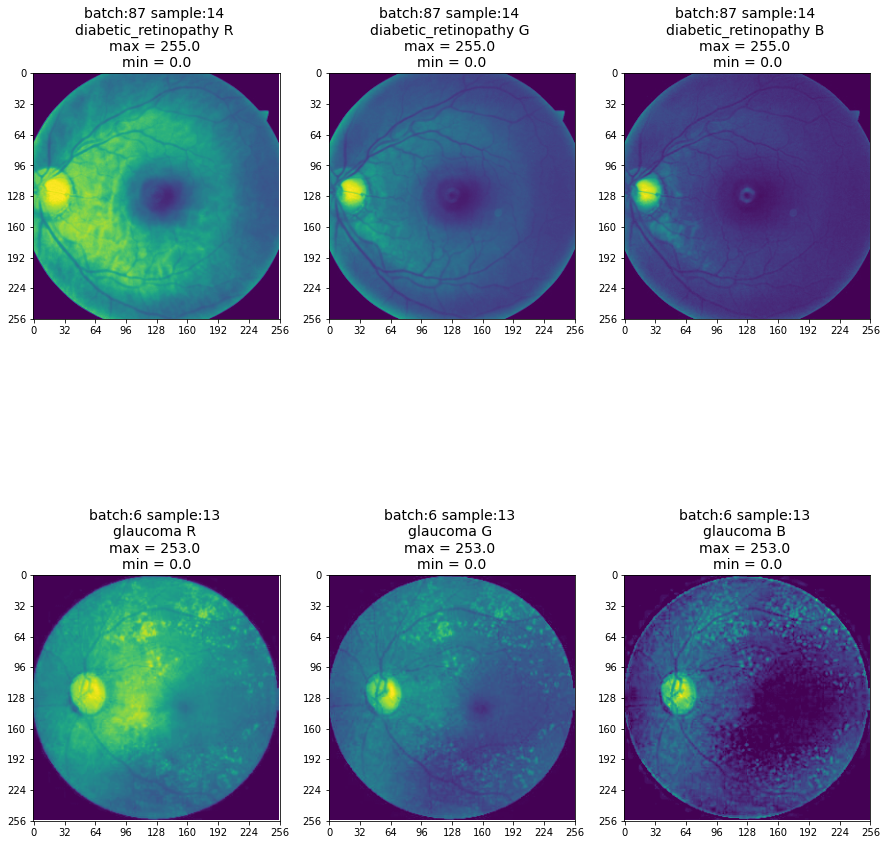

In [ ]:
sampleImage(2, split_channel=True, file_name = "sample_split_01.png")

# Create the model

> parameters are automatically randomized everytime a model is created

### Custom model

In [ ]:
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Resizing, Rescaling, RandomFlip, RandomRotation, Conv2D, AveragePooling2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.activations import relu,softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
from tensorflow.keras.models import load_model

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
model = keras.Sequential(
    [
    Input(shape = (IMAGE_SIZE, IMAGE_SIZE , 3), ),
    Resizing(IMAGE_SIZE,IMAGE_SIZE),
    Rescaling(scale=1./255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(factor=(0.5,0.5)),
     
    Conv2D(128, (1,1), strides = 1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),

    Conv2D(64, (1,1), strides=1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    Conv2D(64, (3,3), strides=2),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    Conv2D(128, (1,1), strides=1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    MaxPooling2D(pool_size=(2,2)),
              
    Conv2D(128, (1,1), strides=1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    Conv2D(128, (3,3), strides=2),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    Conv2D(256, (1,1), strides=1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (1,1), strides=1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    Conv2D(512, (3,3), strides=2),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),
    Conv2D(512, (1,1), strides=1),
    BatchNormalization(),
    Activation(activation = "leaky_relu"),

    Conv2D(64, (3,3), strides=1),
    Activation(activation = "leaky_relu"),
    MaxPooling2D(pool_size=(2,2)),

    AveragePooling2D(1),
    Flatten(),
    Dense(256),
    Activation(activation = "leaky_relu"),
    Dense(128),
    Activation(activation = "leaky_relu"),
    Dense(64),
    Activation(activation = "leaky_relu"),
    Dense(32),
    Activation(activation = "leaky_relu"),
    Dense(4),

    Activation('softmax')
    ]
)

In [ ]:
model.summary()

## Visualize model architecture

### 3D Model

In [ ]:
! pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 40.3 MB/s 


In [ ]:
import visualkeras

# visualkeras.layered_view(model, legend=True, draw_volume=False)
from PIL import ImageFont
from tensorflow.keras import layers
from collections import defaultdict

color_map = defaultdict(dict) #customize the colours
color_map[layers.BatchNormalization]['fill'] = '#00f5d4'
color_map[layers.Activation]['fill'] = '#8338ec'
color_map[layers.MaxPooling2D]['fill'] = '#03045e'
color_map[AveragePooling2D]['fill'] = '#696969'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True, color_map=color_map, draw_volume=True)

NameError: ignored

### Model Summary

In [ ]:
! pip install graphviz
! pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_arch.png", show_shapes=True)

## Set model name

In [ ]:
MODEL_NAME = "ED69"

## Define metrics

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Loading trained model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!gdown 1uezk6JGQX4iqKZLAM_5ahUuOH96lbg_a

Downloading...
From: https://drive.google.com/uc?id=1uezk6JGQX4iqKZLAM_5ahUuOH96lbg_a
To: /content/Eye_Diseases90EZ.h5
100% 582M/582M [00:03<00:00, 156MB/s]


In [ ]:
LOAD_MODEL = True
# DIR="gdrive/MyDrive/CMU Classes/"
DIR=""
if LOAD_MODEL :
  loaded_model = load_model("Eye_Diseases90EZ.h5", custom_objects={"recall": recall_m, "precision":precision_m, "f1":f1_m})
  loaded_model.summary()
  model = loaded_model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 255, 255, 16)      208       
                                                                 
 activation_17 (Activation)  (None, 255, 255, 16)      0         
                                                      

## Select loss function & optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy' , precision_m, recall_m , f1_m])

## Set early stopping callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Train the model

In [ ]:
STARTING_EPOCH = 100
n_epochs_ran = 0

In [ ]:
history = model.fit(train_ds, epochs=100, batch_size=BATCH_SIZE, callbacks=[early_stopping], validation_data=validation_ds)

In [ ]:
n_epochs_ran = len(history.history['loss'])

## Save the model

In [ ]:
MODEL_FULLNAME = "ED69"

In [ ]:
SAVE_MODEL = False
MODEL_FULLNAME = MODEL_NAME+"_e" + str(STARTING_EPOCH + n_epochs_ran)
if(SAVE_MODEL):
  model.save(MODEL_FULLNAME+".h5")

## Save accuracy record to a file

In [ ]:
hist_df = pd.DataFrame(history.history) 

In [ ]:
hist_csv_file = MODEL_FULLNAME + '_hist.csv' 
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Test with test dataset


In [ ]:
test_result = model.evaluate(test_ds)

20/20 [==============================] - 12s 244ms/step - loss: 0.1904 - accuracy: 0.9354 - precision: 0.9376 - recall: 0.9291 - f1: 0.9332


# Result 

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_ds, verbose=0)
print("Loss = " , end= '')
print(loss)
print("Accuracy = " , end = '')
print(accuracy)
print("f1_score = " , end = '')
print(f1_score)
print("Precision = " , end = '')
print(precision)
print("Recall = " , end ='')
print(recall)

Loss = 0.19044554233551025
Accuracy = 0.9354330897331238
f1_score = 0.9375597834587097
Precision = 0.9291087985038757
Recall = 0.9332202672958374


## Accuracy / Loss Graph

In [ ]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
import plotly
# import kaleido
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly import subplots

In [ ]:
# HISTORY_FILE_NAME = MODEL_FULLNAME+"_hist.csv"
HISTORY_FILE_NAME = "ED420.csv"
df = pd.read_csv(HISTORY_FILE_NAME)
# print(df)

Define plot_accuracy_and_loss()

In [ ]:
def create_trace(x,y,ylabel,color):
  trace = go.Scatter(
      x = x, 
      y = y,
      name = ylabel,
      marker = dict(color =color),
      mode = "markers+lines",
      text = x
  )
  return trace

def plot_accuracy_and_loss(df , modelname):
  
  acc = (df['accuracy']*100)
  val_acc = (df['val_accuracy']*100)
  loss = df['loss']
  val_loss = df['val_loss']
  epochs = list(range(1,len(acc)+1))

  trace_ta = create_trace(epochs,acc,"Traning accuracy", "Green")
  trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
  trace_tl = create_trace(epochs,loss,"Training  loss", "Blue")
  trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
  
  title1 = modelname + " Accuracy"
  title2 = modelname + " Loss"
  fig = subplots.make_subplots(rows=2, cols=1, subplot_titles=(title1,title2))
  fig.append_trace(trace_ta,1,1)
  fig.append_trace(trace_va,1,1)
  fig.append_trace(trace_tl,2,1)
  fig.append_trace(trace_vl,2,1)
  fig['layout']['xaxis'].update(title = 'Epoch')
  fig['layout']['xaxis2'].update(title = 'Epoch')
  fig['layout']['yaxis'].update(title = 'Percentage', range=[0,100])
  fig['layout']['yaxis2'].update(title = 'Loss', range=[0,2])
  # fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1], autorange =True)
  # fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1], autorange =True)
  fig.write_image(modelname + "_accloss.png" , width=600 , height=900 )
  plotly.offline.iplot(fig, filename='accuracy-loss')
  # fig.write_image(modelname + "_accloss.png")


In [ ]:
plot_accuracy_and_loss(df , "ED69")

## Graph from all 3 models

In [ ]:
def create_trace(x,y,ylabel,color):
  trace = go.Scatter(
      x = x, 
      y = y,
      name = ylabel,
      marker = dict(color =color),
      mode = "markers+lines",
      text = x
  )
  return trace

def plot_accuracy_and_validacc(df1 , df2 , df3 , modelname1 , modelname2 , modelname3):
  listOfAcc = []
  listOfValAcc = []
  listOfEpoch = []
  listOfDf = [df1 , df2 , df3]
  listOfModelName = [modelname1 , modelname2 , modelname3]
  colorTA = ["Red" , "Green" , "Blue"]
  colorVA = ["Orange" , "Purple" , "Black"]
  listOfTraceTA = []
  listOfTraceVA = []
  for i in range (3) :
    listOfAcc.append(listOfDf[i]['accuracy']*100)
    listOfValAcc.append(listOfDf[i]['val_accuracy']*100)
    listOfEpoch.append(list(range(1,len(listOfAcc[i]+1))))
    listOfTraceTA.append(create_trace(listOfEpoch[i],listOfAcc[i], listOfModelName[i] + " Traning accuracy", colorTA[i]))
    listOfTraceVA.append(create_trace(listOfEpoch[i],listOfValAcc[i], listOfModelName[i] + " Validation accuracy", colorVA[i]))

  title1 = "All 3 Model's Training Accuracy"
  title2 = "All 3 Model's Valid Accuracy"
  fig = subplots.make_subplots(rows=2, cols=1, subplot_titles=(title1,title2))
  for i in range (3) :
    fig.append_trace(listOfTraceTA[i],1,1)
    fig.append_trace(listOfTraceVA[i],2,1)
  fig['layout']['xaxis'].update(title = 'Epoch')
  fig['layout']['xaxis2'].update(title = 'Epoch')
  fig['layout']['yaxis'].update(title = 'Percentage', range=[0,100])
  fig['layout']['yaxis2'].update(title = 'Percentage', range=[0,100])
  fig.write_image("3modelstava.png" , width=750 , height=900 )
  plotly.offline.iplot(fig, filename='3modeltava')


In [ ]:
df1 = pd.read_csv("ed69.csv")
df2 = pd.read_csv("ED11x4.csv")
df3 = pd.read_csv("ED420.csv")

In [ ]:
plot_accuracy_and_validacc(df1 , df2 , df3 , "ED69" , "ED11x4" , "ED420")

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
true_labels = []
predicted_labels = []

for x, y in test_ds:
    true_labels.append(y)
    predicted_labels.append(model.predict(x))
    
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)

1/1 [==============================] - 0s 181ms/step


In [ ]:
true_labels_list = []
predicted_labels_list = [] 

for (tr_lbl, pr_lbl) in zip (true_labels, predicted_labels):
    true_labels_list.append(np.argmax(tr_lbl))
    predicted_labels_list.append(np.argmax(pr_lbl))
    
true_labels_list = np.array(true_labels_list)
predicted_labels_list = np.array(predicted_labels_list)

print(true_labels_list)
print(predicted_labels_list)

cf_matrix = confusion_matrix(y_true=true_labels_list, y_pred=predicted_labels_list, normalize='pred')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [ ]:
def plot_confusion_matrix(file_name = ""):
  labels = ['Cataract', 'Diabatic Retinopathy', 'Glaucoma', 'Normal']

  plt.figure(figsize=(12,12))
  sns.set(font_scale=2.0)
  sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.3f')

  plt.ylabel('True classes')
  yticks, _ = plt.yticks()
  plt.yticks(ticks=yticks, labels=labels, rotation=45)

  plt.xlabel('Predicted classes')
  xticks, _ = plt.xticks()
  plt.xticks(ticks=xticks, labels=labels, rotation=45)
  title = MODEL_NAME + " Eye Diseases Classification"
  plt.title(title)

  if file_name != "":
    plt.savefig(file_name, bbox_inches='tight')

  plt.show()

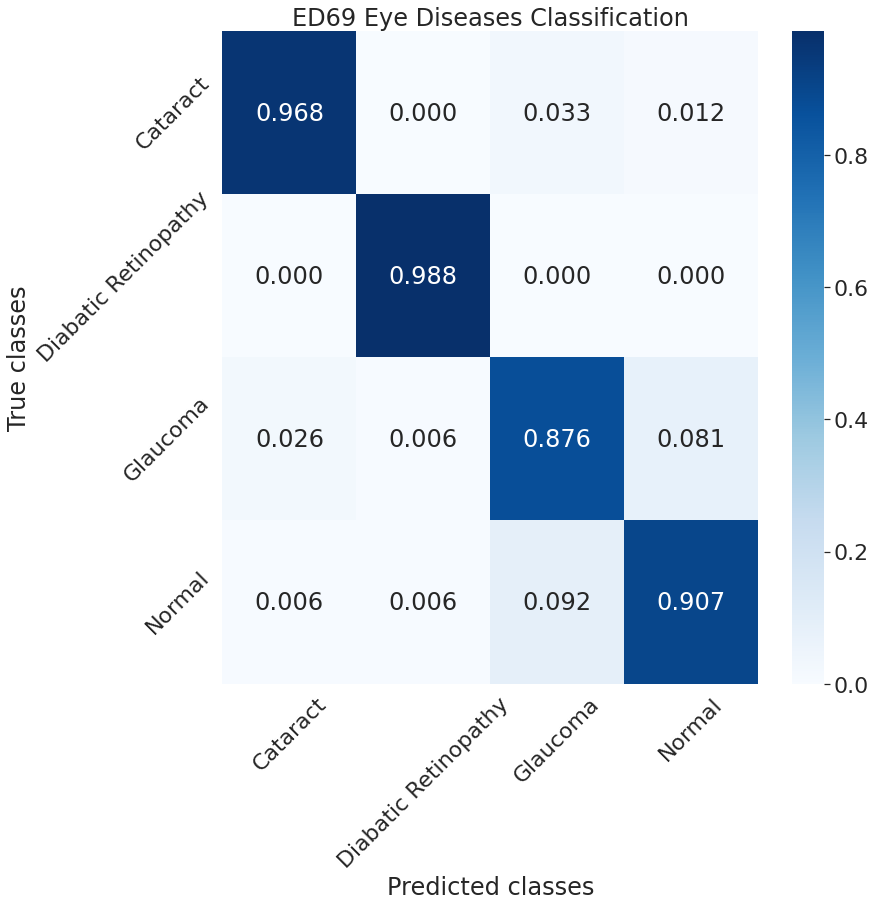

In [ ]:
plot_confusion_matrix("ED69")

## Sample test predictions

### Visualize predictions

Un-batch test set images

In [ ]:
test_npi = test_ds.as_numpy_iterator()
test_np = list(test_npi)

test_dl_img = test_np[0][0]
test_dl_lab = test_np[0][1]
for i in range(1, len(test_np)):
  test_dl_img = np.concatenate( (test_dl_img,test_np[i][0]) )
  test_dl_lab = np.concatenate( (test_dl_lab,test_np[i][1]) )

In [ ]:
print(test_dl_img.shape, test_dl_lab.shape)

(635, 512, 512, 3) (635, 4)


Predict

In [ ]:
predictions = model.predict(test_dl_img)
predictions.shape

NameError: ignored

In [ ]:
test_dl = [test_dl_img, test_dl_lab]

In [ ]:
def prob_to_int(one_hot):
  for i in range(len(one_hot)):
    if(one_hot[i] == one_hot.max()):
      return i
  return -1

labels_map = {
    0: "cataract",
    1: "diabetic_retinopathy",
    2: "glaucoma",
    3: "normal",
}

### Define `plot_predictions()`

In [ ]:
def plot_predictions(predictions, img_count = 1,  first_sample = -1, width = 15, height = 15, file_name = ""):
  
  nRows = int((img_count-1)/3+1)
  fig, ax = plt.subplots(nRows,3,figsize=(height,width))
  fig.subplots_adjust(hspace = 0.6)
  

  for i in range(0,img_count):
    if(first_sample == -1):
      sample_idx = random.randint(0, len(test_dl[0])-1)
    else:
      sample_idx = i

    img = test_dl[0][first_sample+sample_idx]
    label_one_hot = test_dl[1][first_sample+sample_idx]
    label = prob_to_int(label_one_hot)

    pred_label_prob = np.round(predictions[first_sample+sample_idx],2)
    pred_label = prob_to_int(pred_label_prob)

    img = img.astype('uint8')

    if img_count <= 3:
      ax[i].grid(False)
      if i >= img_count:
        ax[i].axis("off")
      else:
        ax[i].imshow(img, cmap='viridis')
        ax[i].set_title(
          f"sample: {first_sample+sample_idx}/{len(test_dl[0])} \ntrue label: {label} {labels_map[label]} \n{label_one_hot}\nprediction: {pred_label} {labels_map[pred_label]}\n{pred_label_prob}", 
          fontsize=14 )
        ax[i].set_xticks(np.arange(0, 256+1, 32))
        ax[i].set_yticks(np.arange(0, 256+1, 32))
        ax[i].tick_params(axis='both', which='major', labelsize=10)
        ax[i].tick_params(axis='both', which='minor', labelsize=8)
    else:
      ax[int(i/3)][i%3].grid(False)
      if i >= img_count:
        ax[int(i/3)][i%3].axis("off")
      else:
        ax[int(i/3)][i%3].imshow(img, cmap='viridis')
        ax[int(i/3)][i%3].set_title(
          f"sample: {first_sample+sample_idx}/{len(test_dl[0])} \ntrue label: {label} {labels_map[label]} \n{label_one_hot}\nprediction: {pred_label} {labels_map[pred_label]}\n{pred_label_prob}", 
          fontsize=14 )
        ax[int(i/3)][i%3].set_xticks(np.arange(0, 256+1, 32))
        ax[int(i/3)][i%3].set_yticks(np.arange(0, 256+1, 32))
        ax[int(i/3)][i%3].tick_params(axis='both', which='major', labelsize=10)
        ax[int(i/3)][i%3].tick_params(axis='both', which='minor', labelsize=8)
  if file_name != "":
    plt.savefig(file_name, bbox_inches='tight')

### Plot

cataract 
	 Testing:  156
   Starts: 0

diabetic_retinopathy 
	 Testing:  165
   Starts: 156

glaucoma 
	 Testing:  152
   Starts: 321
   
normal 
	 Testing:  162
   Starts: 473

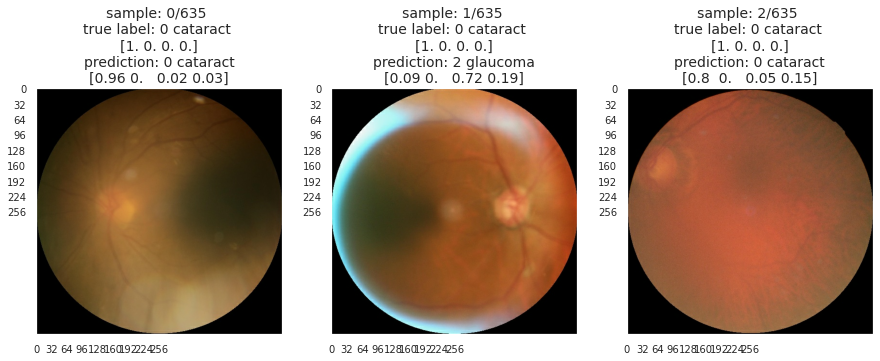

In [ ]:
plot_predictions(predictions, img_count = 3,  first_sample = 0, file_name = MODEL_FULLNAME + "_testpred_cataract.png")

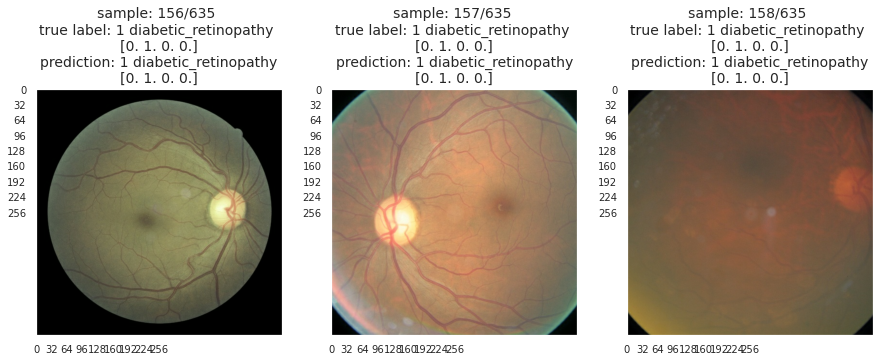

In [ ]:
plot_predictions(predictions, img_count = 3,  first_sample = 156, file_name = MODEL_FULLNAME + "_testpred_diabetic_retinopathy.png")

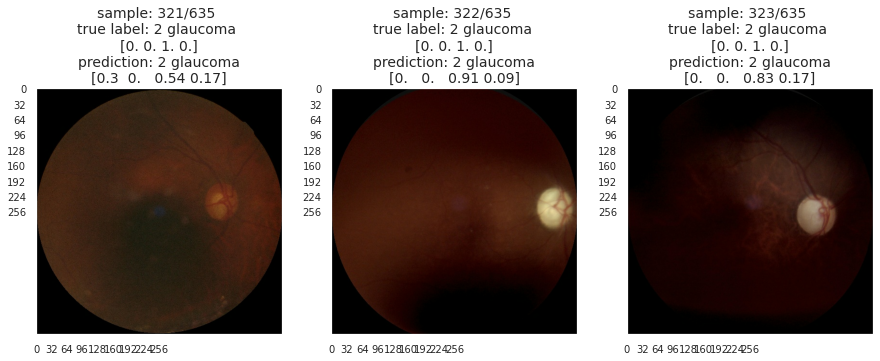

In [ ]:
plot_predictions(predictions, img_count = 3,  first_sample = 321, file_name = MODEL_FULLNAME + "_testpred_glaucoma.png")

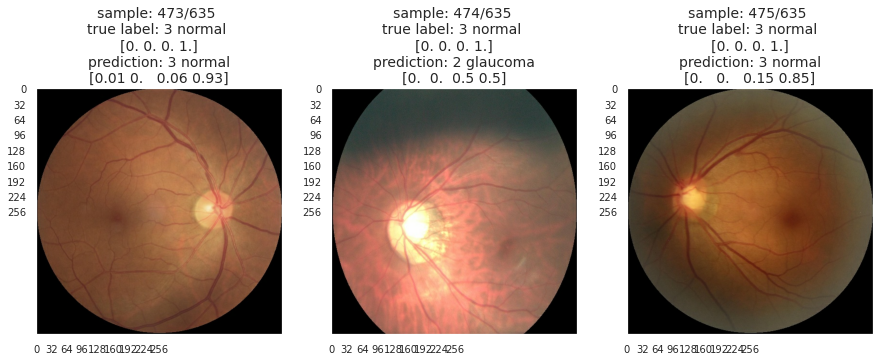

In [ ]:
plot_predictions(predictions, img_count = 3,  first_sample = 473, file_name = MODEL_FULLNAME + "_testpred_normal.png")

## Weight visualization

In [ ]:
model.summary()

### Find Conv2D layer

In [ ]:
layer = model.layers
conv_layer= []
j = 0
for i in layer:
  if "conv" in i.name:
    conv_layer.append(j)
  j+=1
print(conv_layer)  

[4, 6, 9, 11, 14, 16]


### Make short version of the model for feature, weight visualization

In [ ]:
from keras.models import Model
outputs = [model.layers[i].output for i in conv_layer]
model_plot = Model(inputs=model.inputs, outputs=outputs)
# print(model_plot.summary())

`cl` must match layer number in `conv_layer`

In [ ]:
cl = 6 #input interested layer see whole model in .summary
layer = model_plot.layers
filters, biases = model_plot.layers[cl+1].get_weights()
print(layer[cl+1].name, filters.shape)
print(filters.shape[3])
#thrid param is the channel use for ploting ch

conv2d_13 (2, 2, 16, 16)
16


### Input image to sample filter map

single image

In [ ]:
# img = load_img('1020_left.jpg', target_size=(512, 512))
# img = img_to_array(img)
# img = np.expand_dims(img, axis=0)
# feature_output = model_plot.predict(img)

image from train/validation/test set

In [ ]:
img = test_dl[0][0]
label = test_dl[0][1]
img = np.expand_dims(img, axis=0)
feature_output = model_plot.predict(img)

1/1 [==============================] - 7s 7s/step


### Find number of filters of each conv layer

In [ ]:
num_of_filter =[]
for i in conv_layer:
  filters,biasses = model.layers[i].get_weights()
  print(filters.shape[3])
  num_of_filter.append(filters.shape[3])

16
16
64
64
128
128


In [ ]:
cl = 11 #input interested layer see whole model in .summary
layer = model_plot.layers
filters, biases = model_plot.layers[cl+1].get_weights()
print(layer[cl+1].name, filters.shape)
print(filters.shape[3])
#thrid param is the channel use for ploting ch

conv2d_15 (4, 4, 64, 64)
64


### Plot

8 8


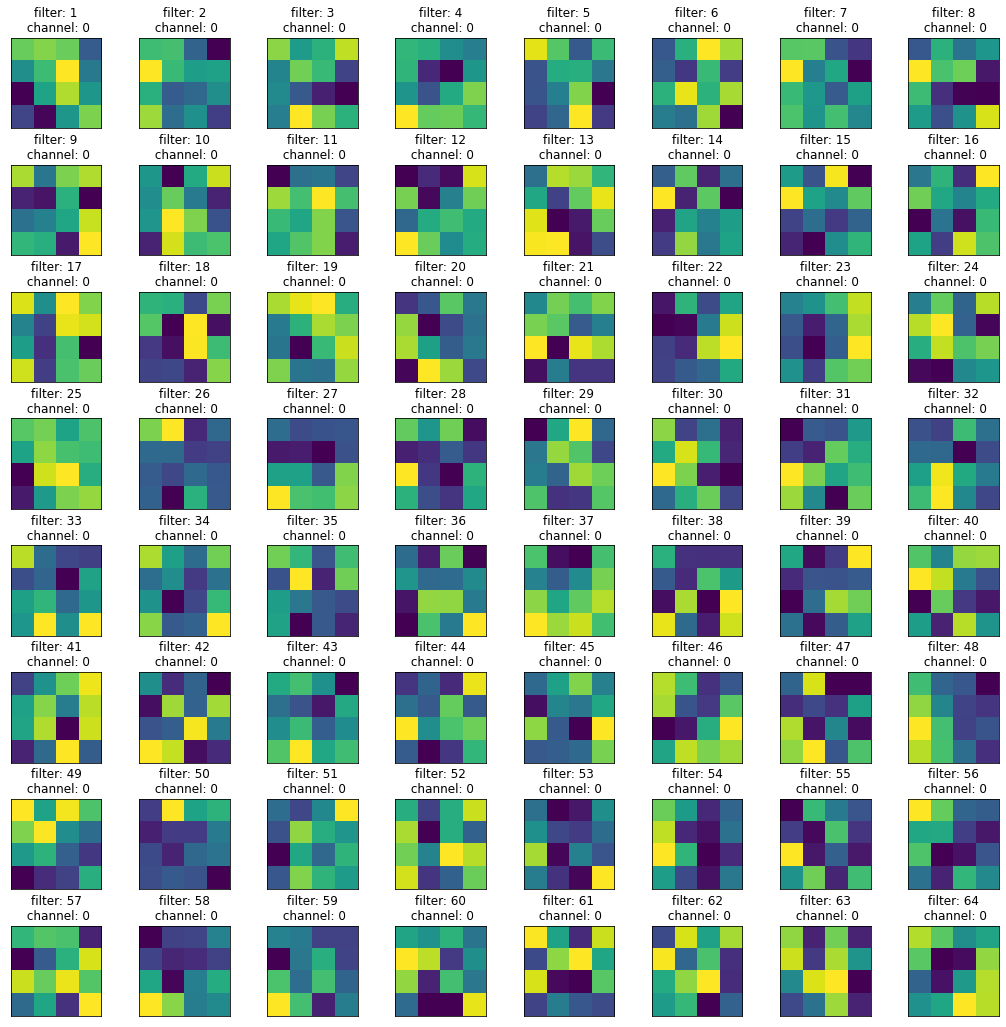

In [ ]:
# input interested channel corresponding to the layer you input 
cl = 9
ch = 0
layer = model_plot.layers
filters,biasses = model_plot.layers[cl+1].get_weights()



# config this  
fig1=plt.figure(figsize=(18, 18))
columns = 8
rows = 8




print(columns,rows)
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i,)
    fig1.set_xticks([])  
    fig1.set_yticks([])
    # fig1.tight_layout()
    plt.imshow(f[:, :, ch]) #Show only the filters from ch channel (R)
    plt.title("filter: "+ str(i)+"\n channel: "+str(ch), fontsize=12)
    # plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
      #ix += 1
plt.show()

8 8


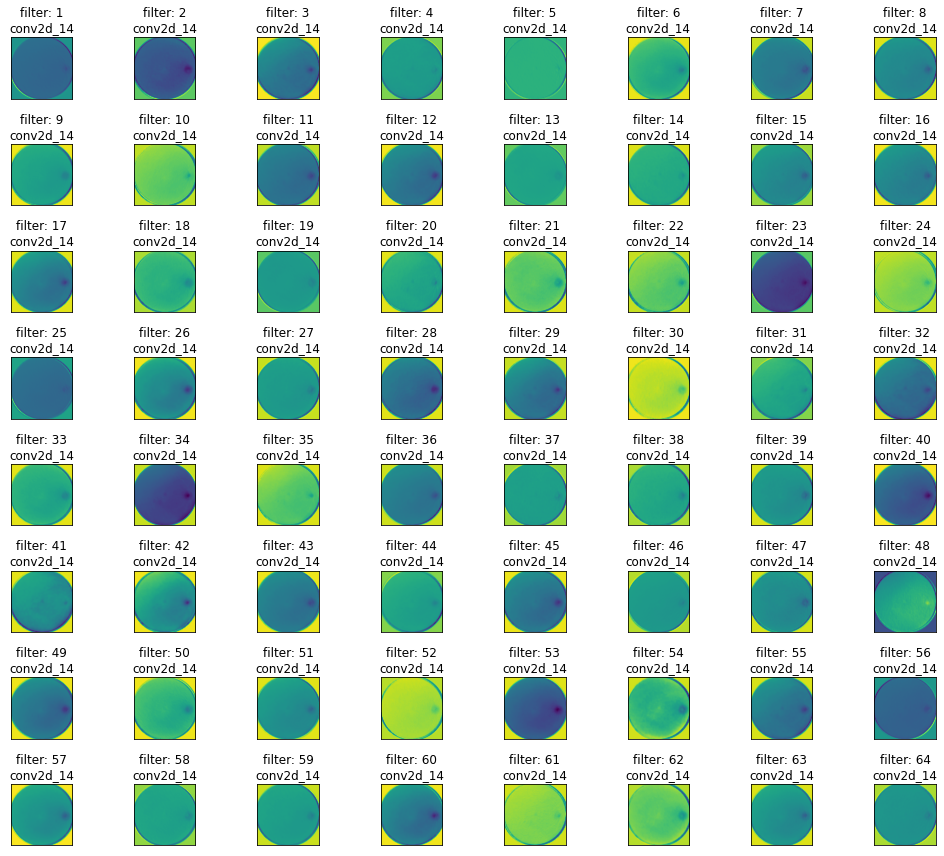

In [ ]:
layer = model.layers
k= 2
ftr = feature_output[k]
    
num = num_of_filter[k]
if(num>=24):
  fig=plt.figure(figsize=(14, 12))


  columns = 8
  r = num/8
else:
  fig=plt.figure(figsize=(12, 8))
  columns = 4
  r = num/4
rows = int(r)
print(columns,rows)
for i in range(1, columns*rows +1):
    fig =plt.subplot(rows, columns, i)
    fig.set_xticks([]) 
    fig.set_yticks([])
    plt.imshow(ftr[0, :, :, i-1])
    plt.title("filter: "+ str(i) + "\n"+layer[conv_layer[k]].name, fontsize=12)
    # plt.subplots_adjust(hspace=0.6,wspace=0.4)
plt.tight_layout()
plt.show()
k+=1